## Slicing the nii files

In [1]:
import glob, os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [244]:
#im_path = "./MRI_Data/Val/RVolumes"
#out_path = "./MRI_Data/Val/RS10Volumes"

im_path = './Data/Raw/OSIC_Fibrosis/Volumes/'
msk_path = './Data/Raw/OSIC_Fibrosis/Labels/'

img_out_path = './Data/Processed/Volumes/'
msk_out_path = './Data/Processed/Labels/'

volume_type = '*.nrrd'

In [245]:
images = glob.glob(os.path.join(im_path, volume_type))
images_IDs = [name.split("/")[-1] for name in images]
print(images_IDs)

['ID00119637202215426335765_lung.nrrd', 'ID00319637202283897208687_lung.nrrd', 'ID00007637202177411956430_lung.nrrd', 'ID00131637202220424084844_lung.nrrd', 'ID00025637202179541264076_lung.nrrd', 'ID00075637202198610425520_lung.nrrd', 'ID00358637202295388077032_lung.nrrd', 'ID00061637202188184085559_lung.nrrd', 'ID00192637202245493238298_lung.nrrd', 'ID00102637202206574119190_lung.nrrd', 'ID00337637202286839091062_lung.nrrd', 'ID00168637202237852027833_lung.nrrd', 'ID00207637202252526380974_lung.nrrd', 'ID00229637202260254240583_lung.nrrd', 'ID00335637202286784464927_lung.nrrd', 'ID00323637202285211956970_lung.nrrd', 'ID00305637202281772703145_lung.nrrd', 'ID00186637202242472088675_lung.nrrd', 'ID00355637202295106567614_lung.nrrd', 'ID00077637202199102000916_lung.nrrd', 'ID00264637202270643353440_lung.nrrd', 'ID00076637202199015035026_lung.nrrd', 'ID00285637202278913507108_lung.nrrd', 'ID00411637202309374271828_lung.nrrd', 'ID00241637202264294508775_lung.nrrd', 'ID002226372022590662297

In [246]:
#resample code
def downsamplePatient(patient_CT, resize_factor=2):

    #original_CT = sitk.ReadImage(patient_CT)
    original_CT = patient_CT
    dimension = original_CT.GetDimension()
    reference_physical_size = np.zeros(original_CT.GetDimension())
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(original_CT.GetSize(), original_CT.GetSpacing(), reference_physical_size)]
    
    reference_origin = original_CT.GetOrigin()
    reference_direction = original_CT.GetDirection()
    print('Input size', original_CT.GetSize())
    reference_size = [round(sz/resize_factor) for sz in original_CT.GetSize()] 
    reference_size = (256,256,original_CT.GetSize()[2])
    #print(reference_size)
    reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

    reference_image = sitk.Image(reference_size, original_CT.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(original_CT.GetDirection())

    transform.SetTranslation(np.array(original_CT.GetOrigin()) - reference_origin)
  
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(original_CT.TransformContinuousIndexToPhysicalPoint(np.array(original_CT.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0)

#resample MRI code
def downsampleMRI(patient_MRI, resize_factor=(1,256/320,256/290)):
    from scipy.ndimage import zoom
    img_arr = sitk.GetArrayFromImage(patient_MRI)[:,80:300,0:200]
    new_array = zoom(img_arr, (1, 256/220, 256/200))
    return new_array

def convert_binary(input):
    BinThreshImFilt = sitk.BinaryThresholdImageFilter()
    BinThreshImFilt.SetLowerThreshold(0.1)
    BinThreshImFilt.SetOutsideValue(0)
    BinThreshImFilt.SetInsideValue(1)
    BinIm = BinThreshImFilt.Execute(input)
    BinImA = sitk.GetArrayFromImage(BinIm)
    return BinImA

In [247]:
segment_volume = False
segment_mri = False

for name in images_IDs:
    img_X = sitk.ReadImage(os.path.join(msk_path,name), sitk.sitkFloat32)
    sample_arr = sitk.GetArrayFromImage(img_X)
    image_is_bigger = sample_arr.shape[0] > 100
    #print(sample_arr.shape)
    if image_is_bigger:
        #CT Volume
        if segment_volume is True:
            print('Segmenting volume', name)
            img_X = sitk.Clamp(img_X, upperBound=1000, lowerBound=-1000)
            img_X = downsamplePatient(img_X)
            img_X = sitk.RescaleIntensity(img_X, -1, 1)
            img_arr = sitk.GetArrayFromImage(img_X)
            img_arr = np.moveaxis(img_arr,0,2)

        #Binarization
        if segment_volume is False:
            #name = name.replace('L','')
            print('Segmenting Label ', name)
            img_X = downsamplePatient(img_X)
            img_arr = convert_binary(img_X)
            img_arr = np.moveaxis(img_arr,0,2)
            print(np.unique(img_arr))


        #MRIVolume
        if segment_mri is True:
            img_arr = downsampleMRI(img_X) # if CT use get array from image

        #defining standard origins    
        origin =img_X.GetOrigin()
        direction = img_X.GetDirection()
        space = img_X.GetSpacing()
        img_arr = img_arr[:,:,70:102]
        print('output size ', img_arr.shape)
        savedImg = sitk.GetImageFromArray(img_arr)
        sitk.WriteImage(savedImg, os.path.join(msk_out_path,name))
        
    else:
        pass

Segmenting Label  ID00131637202220424084844_lung.nrrd
Input size (512, 512, 210)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00075637202198610425520_lung.nrrd
Input size (512, 512, 320)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00358637202295388077032_lung.nrrd
Input size (632, 632, 312)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00061637202188184085559_lung.nrrd
Input size (512, 512, 253)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00192637202245493238298_lung.nrrd
Input size (512, 512, 245)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00102637202206574119190_lung.nrrd
Input size (512, 512, 233)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00168637202237852027833_lung.nrrd
Input size (512, 512, 253)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00323637202285211956970_lung.nrrd
Input size (512, 512, 258)
[0 1]
output size  (256, 256, 32)
Segmenting Label  ID00186637202242472088675_lung.nrrd
Input size (512, 512, 408)

## Reading the dimensions

In [248]:
images = glob.glob(os.path.join(img_out_path, volume_type))
images_IDs = [name.split("/")[-1] for name in images]

for name in images_IDs:
    print(name)
    img_X = sitk.ReadImage(os.path.join(img_out_path,name), sitk.sitkFloat32)
    #img_X = sitk.RescaleIntensity(img_X, -1, 1)
    #img_X = convert_binary(img_X)
    img_arr = sitk.GetArrayFromImage(img_X)
    print('name {} dimension {}'.format(name, img_arr.shape))
    break
print(np.unique(img_arr))

ID00411637202309374271828_lung.nrrd
name ID00411637202309374271828_lung.nrrd dimension (256, 256, 32)
[-1.        -0.9999997 -0.9999992 ...  0.999989   0.9999902  1.       ]


[-1.        -0.9999997 -0.9999992 ...  0.999989   0.9999902  1.       ]


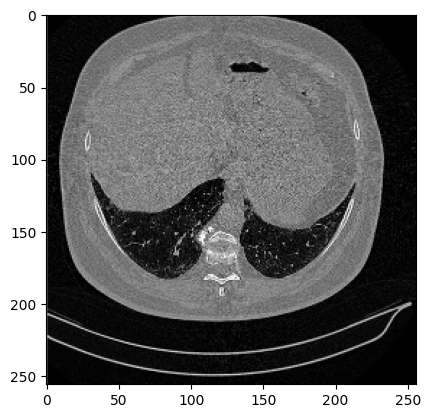

In [249]:
import matplotlib.pyplot as plt
plt.imshow(img_arr[:,:,20], cmap = 'gray')
print(np.unique(img_arr))

## check every slice with labels

In [2]:
import glob, os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# CT dataset
im_path = './Data/Processed/Test/Volumes/'
msk_path = './Data/Processed/Test/Labels/'
slice_number = 20
mask_present = True

#im_path = "./MRI_Data/Val/RS10Volumes"
#msk_path = "./MRI_Data/Val/RS10Labels"

S13.nii.gz
mskarr  (256, 256, 32) max val  0.7590857 min val  0.0


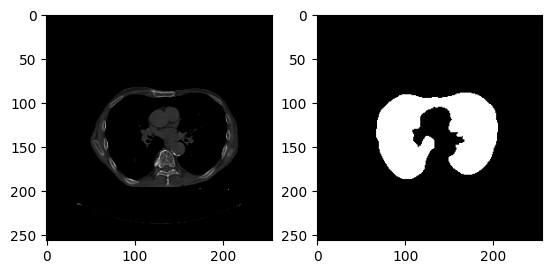

imgarr  (256, 256, 32) max val  0.7590857 min val  -1.0
S11.nii.gz
mskarr  (256, 256, 32) max val  1.0 min val  0.0


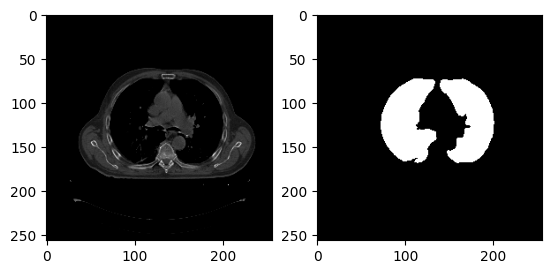

imgarr  (256, 256, 32) max val  1.0 min val  -1.0
S12.nii.gz
mskarr  (256, 256, 32) max val  0.112913206 min val  0.0


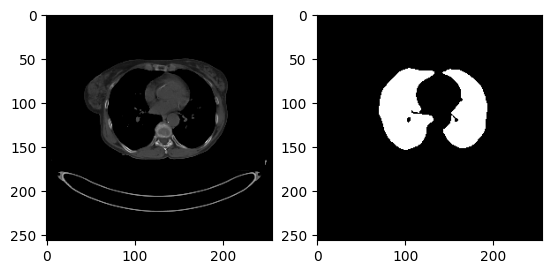

imgarr  (256, 256, 32) max val  0.112913206 min val  -1.0
S14.nii.gz
mskarr  (256, 256, 32) max val  1.0 min val  0.0


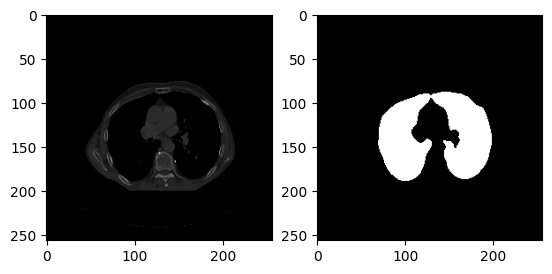

imgarr  (256, 256, 32) max val  1.0 min val  -1.0


In [6]:
images = glob.glob(os.path.join(im_path, "*.nii.gz")) + glob.glob(os.path.join(im_path, "*.nrrd"))
images_IDs = [name.split("/")[-1] for name in images]

def plot_graphs(img, msk, slice_number):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img[:,:, slice_number], cmap = 'gray')
    if mask_present:
        ax[1].imshow(msk[:,:,slice_number], cmap = 'gray')
    plt.show()

for name in images_IDs:
    print(name)
    img_X = sitk.ReadImage(os.path.join(im_path,name), sitk.sitkFloat32)
    img_arr = sitk.GetArrayFromImage(img_X)
    #img_arr = np.moveaxis(img_arr,[0],[2])
    #name = str(name).replace('.nrrd','') + '.seg.nrrd'
    if mask_present:
        Mask_X = sitk.ReadImage(os.path.join(msk_path,name), sitk.sitkFloat32)
        msk_arr = sitk.GetArrayFromImage(Mask_X)
        #msk_arr = np.moveaxis(msk_arr,[0],[2])
        print('mskarr ' , msk_arr.shape, 'max val ', np.max(img_arr), 'min val ', np.min(msk_arr))
        plot_graphs(img_arr, msk_arr, slice_number)
        print('imgarr ' , img_arr.shape, 'max val ', np.max(img_arr), 'min val ', np.min(img_arr))
    #plt.imshow(img_arr[:,:,slice_number], cmap='gray')
    #plt.show()

In [3]:
import wandb
from wandb.keras import WandbCallback
wandb.init(project="CT-Unet-Train", entity="subinek")

2022-11-04 11:52:55.142561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:52:55.289271: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 11:52:55.784300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-04 11:52:55.784372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
!git config --global --add safe.directory '/home/erattakulangara'

In [1]:
import os
print(os.getcwd())

/home/erattakulangara/hpchome/DeepLearningAlgo/2022_3D_Unet_segmentation/3D_Unet/ver_14.0_Train_CTData
